In [ ]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import fsolve
from scipy.optimize import root

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Physical constants and parameters
entropy_change_vaporization = {
    "incipient": 17 * 4.184,  # cal/mol/K to J/mol/K
    "total": 34.9 * 4.184,   # cal/mol/K to J/mol/K
}
melting_temperature = 1996  # K
vaporization_temperature = 3175  # K
mean_atomic_weight = 20.03  # g/mol
Eiv = 2.39E+06  # J/kg/K
Ecv = 1.43E+07  # J/kg/K

C0 = 2.22*1e3
s = 1.61
gruneisen_ratio = 1.32  # dimensionless

TL_RHO0 = 2.53E+03  # kg/m^3
TL_CHEAT = 7.53E+02  # J/kg/K
TL_BULKA = 4.54E+10  # Pa
# print('Old Bulk A',TL_BULKA )
# TL_BULKA = TL_RHO0* C0**2 # Pa
# print('New Bulk A',TL_BULKA )
TL_THERMA = 5.00E-01  # dimensionless
TL_THERMB = 8.20E-01  # dimensionless
TL_ALPHA = 5.00E+00  # dimensionless
TL_BETA = 5.00E+00  # dimensionless

E_int =  TL_CHEAT * 296# E = CvT = 1 [kJ/kg/K]* 300 [K] 
P_int = 1e5
##########################
##########################
TL_BULKBs = [5e5,1e6,5e6,1.0E7,5e7,1e8] 
TL_EZEROs = [1e6,5e6,1E7,5e7,1e8]
##########################
##########################

pre_tillos = []
shock_vel_tillos = []
particle_vel_tillos = []
labels = []

######
particle_vel = np.arange(0,5,0.1)*1e3
Shock_vel_Hugo = C0+particle_vel*s
Shock_Pre_Hugo = TL_RHO0*particle_vel*Shock_vel_Hugo + P_int
Shock_Den_Hugo = TL_RHO0*Shock_vel_Hugo/(Shock_vel_Hugo-particle_vel)
Shock_Vol_Hugo = 1/Shock_Den_Hugo/vol_int

rho_tillo = np.arange(TL_RHO0,1e4,50)
etha = rho_tillo/TL_RHO0
mu = etha-1
vol_int =1/TL_RHO0
vol_tillo = 1/rho_tillo/vol_int

# Function to calculate pressure with debugging
def pressure_tillotson(vars, rho, rho0, a, b, A, B, E0):
    P,E= vars
    mu = rho / rho0 - 1
    etha = mu + 1
    f1 = E -(0.5 * (P + P_int) * (1 / rho0 - 1 / rho) + E_int)  # Internal energy
    f2 = P-((
        (a + b / (E / (E0 * etha**2) + 1)) * rho * E
        + A * mu
        + B * mu**2))
    return f1,f2



def till_eos(TL_BULKB,TL_EZERO,pressure_results):
    pre_tillo = np.array(pressure_results)  # Convert list to numpy array 
    # Calculate shock_vel_tillo and particle_vel_tillo
    shock_vel_tillo = np.sqrt((pre_tillo - P_int) * rho_tillo / ((rho_tillo - TL_RHO0) * TL_RHO0))
    particle_vel_tillo = np.sqrt((pre_tillo - P_int) / rho_tillo * (rho_tillo/TL_RHO0-1))
    return pre_tillo,shock_vel_tillo,particle_vel_tillo

for i in np.arange(5,6,1):
  for j in np.arange(4,5,1):
      TL_BULKB = TL_BULKBs[i]
      TL_EZERO = TL_EZEROs[j]
      pressure_results = []
      for rho in rho_tillo:
          mu = rho / TL_RHO0 - 1
          etha = mu + 1
          P0_E0 = [0,0]
          P0_E0[0] = max(1e5, TL_BULKA * (rho / TL_RHO0 - 1) + P_int)
          P0_E0[1] = 0.5 * P0_E0[0] * (1 / TL_RHO0 - 1 / rho) + E_int


          # P_sol = fsolve(pressure_tillotson, P0, args=(rho, TL_RHO0, TL_THERMA, TL_THERMA, TL_BULKA, TL_BULKB, TL_EZERO))
          solution = root(pressure_tillotson,P0_E0,method='broyden1',args=(rho, TL_RHO0, TL_THERMA, TL_THERMA, TL_BULKA, TL_BULKB, TL_EZERO))
          # 結果の表示
          if solution.success:
              P_sol, E_sol = solution.x
              print("Solution:")
              print(f"rho: {rho}, rho0: {TL_RHO0}")
              print(f"mu: {mu}")
              print(f"etha: {etha}")
          else:
              print("!!!!!!!!!!!!!!!!!!!Failed to converge!!!!!!!!!!!!!!!!!!!!!!")
              print("Failed to converge at rho:", rho)
              print("Initial guess P0, E0:", P0_E0)

          pressure_results.append(P_sol)
      tillos = till_eos(TL_BULKB,TL_EZERO,pressure_results)
      ax[0].plot(tillos[2]*1e-3,tillos[1]*1e-3, label="TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(TL_BULKBs[i]*1e-9,TL_EZEROs[j]*1e-6))
      ax[1].plot(vol_tillo,tillos[0]*1e-9, label="TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(TL_BULKBs[i]*1e-9,TL_EZEROs[j]*1e-6))

# Plot 1: Particle velocity vs Shock velocity
ax[0].plot(particle_vel*1e-3, Shock_vel_Hugo*1e-3, label="Shock Velocity (Hugoniot)",linewidth=5,c='red')
ax[0].set_xlabel("Particle Velocity (km/s)")
ax[0].set_ylabel("Shock Velocity (km/s)")
ax[0].set_title("Particle Velocity vs Shock Velocity")
ax[0].grid(True)
ax[0].set_xlim([0,5])
ax[0].set_ylim([0,10])

# Plot 2: Shock volume vs Shock pressure
ax[1].plot(Shock_Vol_Hugo, Shock_Pre_Hugo*1e-9, label="Shock Pressure (Hugoniot)",linewidth=5,c='red')
ax[1].set_xlabel("Volume compression")
ax[1].set_ylabel("Shock Pressure (GPa)")
ax[1].set_title("Volume compression vs Shock Pressure")
ax[1].grid(True)
ax[1].set_xlim([0.4,1.5])
ax[1].set_ylim([0,125])


ax[0].legend()
ax[1].legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

In [158]:
np.array(P_sol[0])*1e-9
np.array(P_sol[1])*1e-6

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
import matplotlib as mpl
#mpl.use('Cairo') #for png, ps, pdf, svg, ...
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from scipy.optimize import fsolve

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# # Physical constants and parameters
# entropy_change_vaporization = {
#     "incipient": 17 * 4.184,  # cal/mol/K to J/mol/K
#     "total": 34.9 * 4.184,   # cal/mol/K to J/mol/K
# }
melting_temperature = 1996  # K
vaporization_temperature = 3175  # K
mean_atomic_weight = 20.03  # g/mol
Eiv = 2.39E+06  # J/kg/K
Ecv = 1.43E+07  # J/kg/K

C0 = 5.297*1e3
s = 1.372
gruneisen_ratio = 1.32  # dimensionless

TL_RHO0 = 2.7E+03  # kg/m^3
TL_CHEAT = 8.96E+02  # J/kg/K
TL_BULKA = 7.52E+10  # Pa
# print('Old Bulk A',TL_BULKA )
# TL_BULKA = TL_RHO0* C0**2 # Pa
# print('New Bulk A',TL_BULKA )
TL_THERMA = 0.50  # dimensionless
TL_THERMB = 1.63  # dimensionless
TL_ALPHA = 5.00E+00  # dimensionless
TL_BETA = 5.00E+00  # dimensionless

E_int =  TL_CHEAT * 296# E = CvT = 1 [kJ/kg/K]* 300 [K] 
P_int = 1e5
##########################
##########################
TL_BULKBs = [6.5e10] 
TL_EZEROs = [5e6]
##########################
##########################

pre_tillos = []
shock_vel_tillos = []
particle_vel_tillos = []
labels = []

######
particle_vel = np.arange(0,5,0.1)*1e3
Shock_vel_Hugo = C0+particle_vel*s
Shock_Pre_Hugo = TL_RHO0*particle_vel*Shock_vel_Hugo + P_int
Shock_Den_Hugo = TL_RHO0*Shock_vel_Hugo/(Shock_vel_Hugo-particle_vel)
Shock_Vol_Hugo = 1/Shock_Den_Hugo/vol_int

rho_tillo = np.arange(2500,1e4,50)
etha = rho_tillo/TL_RHO0
mu = etha-1
vol_int =1/TL_RHO0
vol_tillo = 1/rho_tillo/vol_int

# Function to calculate pressure with debugging
def pressure_tillotson(vars, rho, rho0, a, b, A, B, E0):
    P,E= vars
    mu = rho / rho0 - 1
    etha = mu + 1
    f1 = E -(0.5 * (P + P_int) * (1 / rho0 - 1 / rho) + E_int)  # Internal energy
    f2 = P-(((a + b / (E / (E0 * etha**2) + 1)) * rho * E + A * mu + B * mu**2))
    return f1,f2


def hugonio_eos(TL_BULKB,TL_EZERO,pressure_results):
    pre_tillo = np.array(pressure_results)  # Convert list to numpy array 
    # Calculate shock_vel_tillo and particle_vel_tillo
    shock_vel_tillo = np.sqrt((pre_tillo - P_int) * rho_tillo / ((rho_tillo - TL_RHO0) * TL_RHO0))
    particle_vel_tillo = np.sqrt((pre_tillo - P_int) / rho_tillo * (rho_tillo/TL_RHO0-1))
    return pre_tillo,shock_vel_tillo,particle_vel_tillo

for i in np.arange(0,1,1):
  for j in np.arange(0,1,1):
      TL_BULKB = TL_BULKBs[i]
      TL_EZERO = TL_EZEROs[j]
      pressure_results = []
      for rho in rho_tillo:
          P0_E0 = [0,0]
          P0_E0[0] = max(1e5, TL_BULKA * (rho / TL_RHO0 - 1) + P_int)
          P0_E0[1] = 0.5 * P0_E0[0] * (1 / TL_RHO0 - 1 / rho) + E_int
          # P_sol = fsolve(pressure_tillotson, P0, args=(rho, TL_RHO0, TL_THERMA, TL_THERMA, TL_BULKA, TL_BULKB, TL_EZERO))
          solution = root(pressure_tillotson,P0_E0,method='lm',args=(rho, TL_RHO0, TL_THERMA, TL_THERMB, TL_BULKA, TL_BULKB, TL_EZERO))
          # 結果の表示
          if solution.success:
              P_sol, E_sol = solution.x
              print("Success")
          else:
              print("!!!!!!!!!!!!!!!!!!!Failed to converge!!!!!!!!!!!!!!!!!!!!!!")
              print("Failed to converge at rho:", rho)
              print("Initial guess P0, E0:", P0_E0)

          pressure_results.append(P_sol)
      tillos = hugonio_eos(TL_BULKB,TL_EZERO,pressure_results)
      ax[0].plot(tillos[2]*1e-3,tillos[1]*1e-3, label="TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(TL_BULKBs[i]*1e-9,TL_EZEROs[j]*1e-6))
      ax[1].plot(vol_tillo,tillos[0]*1e-9, label="TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(TL_BULKBs[i]*1e-9,TL_EZEROs[j]*1e-6))

# Plot 1: Particle velocity vs Shock velocity
ax[0].plot(particle_vel*1e-3, Shock_vel_Hugo*1e-3, label="Shock Velocity (Hugoniot)",linewidth=5,c='red')
ax[0].set_xlabel("Particle Velocity (km/s)")
ax[0].set_ylabel("Shock Velocity (km/s)")
ax[0].set_title("Particle Velocity vs Shock Velocity")
ax[0].grid(True)
ax[0].set_xlim([0,5])
ax[0].set_ylim([0,10])

# Plot 2: Shock volume vs Shock pressure
ax[1].plot(Shock_Vol_Hugo, Shock_Pre_Hugo*1e-9, label="Shock Pressure (Hugoniot)",linewidth=5,c='red')
ax[1].set_xlabel("Volume compression")
ax[1].set_ylabel("Shock Pressure (GPa)")
ax[1].set_title("Volume compression vs Shock Pressure")
ax[1].grid(True)
ax[1].set_xlim([0.4,1.5])
ax[1].set_ylim([0,125])


ax[0].legend()
ax[1].legend()

# Adjust layout and display
plt.tight_layout

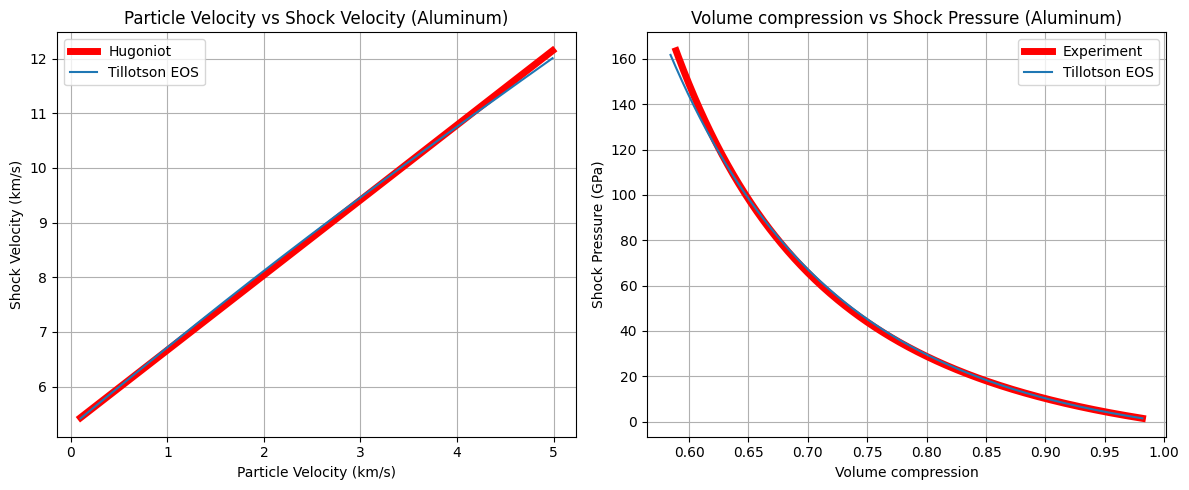

In [273]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
%matplotlib inline
from scipy.interpolate import interp1d

C0 = 5.297*1e3
s = 1.372
gruneisen_ratio = 1.32  # dimensionless

TL_RHO0 = 2.7E+03  # kg/m^3
TL_CHEAT = 8.96E+02  # J/kg/K
TL_BULKA = 7.52E+10  # Pa
# print('Old Bulk A',TL_BULKA )
# TL_BULKA = TL_RHO0* C0**2 # Pa
# print('New Bulk A',TL_BULKA )
TL_THERMA = 0.50  # dimensionless
TL_THERMB = 1.63  # dimensionless
TL_ALPHA = 5.00E+00  # dimensionless
TL_BETA = 5.00E+00  # dimensionless

E_int =  TL_CHEAT * 296# E = CvT = 1 [kJ/kg/K]* 300 [K] 
P_int = 1e5
##########################
##########################
TL_BULKBs = [6.5e10] 
TL_EZEROs = [5e6]
##########################
##########################

pre_tillos = []
shock_vel_tillos = []
particle_vel_tillos = []
labels = []

######
# 粒子速度の範囲を設定（m/s）
particle_vel = np.arange(0.1, 5.0, 0.01) * 1e3


Shock_vel_Hugo = C0+particle_vel*s
Shock_Pre_Hugo = TL_RHO0*particle_vel*Shock_vel_Hugo + P_int
Shock_Den_Hugo = TL_RHO0*Shock_vel_Hugo/(Shock_vel_Hugo-particle_vel)
Shock_Vol_Hugo = 1/Shock_Den_Hugo/vol_int

# Tillotson EOS
def tillotson_eos(rho, E):
    mu = rho / TL_RHO0 - 1
    etha = mu + 1
    P = (
        (a + b / (E / (TL_EZERO * etha**2) + 1)) * rho * E
        + TL_BULKA * mu
        + TL_BULKB * mu**2
    )
    return P

# 連立方程式を定義
def equations(vars, v_p):
    rho, D, P = vars
    # 内部エネルギー E
    E = 0.5 * (P + P_int) * (1 / TL_RHO0 - 1 / rho)
    # Tillotson EOS
    eq1 = P - tillotson_eos(rho, E)
    # 運動量保存
    eq2 = (P - P_int) -  TL_RHO0*D*v_p
    # 質量保存
    eq3 = v_p*rho - (rho - TL_RHO0)*D
    return [eq1, eq2, eq3]


# 結果を保存するリスト
shock_vel_valid = []
pressure_valid = []
volume_ratio_valid = []
particle_vel_valid = []

# 計算ループ
for i in np.arange(0,1,1):
    for j in np.arange(0,1,1):
        TL_BULKB = TL_BULKBs[i]
        TL_EZERO = TL_EZEROs[j]
        for v_p in particle_vel:
            # 初期値の設定 [rho, D, P]
            initial_guess = [TL_RHO0 * 1.1, v_p * 1.1, P_int * 1.1]
            sol = root(equations, initial_guess, args=(v_p,), method="lm")
            if sol.success:
                rho, D, P = sol.x
                V_V0 = TL_RHO0 / rho  # 体積比 V/V0
                particle_vel_valid.append(v_p)
                shock_vel_valid.append(D)
                pressure_valid.append(P)
                volume_ratio_valid.append(V_V0)
                # print(f"Success: v_p = {v_p / 1e3:.2f} km/s -> D = {D / 1e3:.2f} km/s, rho = {rho:.2f} kg/m^3, P = {P:.2e} Pa")
            else:
                print(f"Failed to converge for v_p = {v_p / 1e3:.2f} km/s")

# リストを numpy 配列に変換
particle_vel_valid = np.array(particle_vel_valid)
shock_vel_valid = np.array(shock_vel_valid)
pressure_valid = np.array(pressure_valid)
volume_ratio_valid = np.array(volume_ratio_valid)

# 有効範囲内でのみ補間を行う
interp_shock_vel = interp1d(particle_vel_valid, shock_vel_valid, kind="linear", bounds_error=False, fill_value=np.nan)
interp_pressure = interp1d(particle_vel_valid, pressure_valid, kind="linear", bounds_error=False, fill_value=np.nan)
interp_volume_ratio = interp1d(particle_vel_valid, volume_ratio_valid, kind="linear", bounds_error=False, fill_value=np.nan)

# 有効範囲内の粒子速度を取得
valid_range = (particle_vel >= particle_vel_valid.min()) & (particle_vel <= particle_vel_valid.max())
particle_vel_interp = particle_vel[valid_range]

# 補間後のデータを計算（有効範囲内）
shock_vel_interp = interp_shock_vel(particle_vel_interp)
pressure_interp = interp_pressure(particle_vel_interp)
volume_ratio_interp = interp_volume_ratio(particle_vel_interp)

# 異常値の除去（例：負の値や急激な変化）
shock_vel_interp = np.where(shock_vel_interp < 0, np.nan, shock_vel_interp)
pressure_interp = np.where(pressure_interp < 0, np.nan, pressure_interp)
volume_ratio_interp = np.where(volume_ratio_interp < 0, np.nan, volume_ratio_interp)

# プロット
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 粒子速度 vs 衝撃波速度
ax[0].plot(particle_vel*1e-3, Shock_vel_Hugo*1e-3, label="Hugoniot", linewidth=5, c='red')
ax[0].plot(particle_vel_interp / 1e3, shock_vel_interp / 1e3, label="Tillotson EOS")
ax[0].set_xlabel("Particle Velocity (km/s)")
ax[0].set_ylabel("Shock Velocity (km/s)")
ax[0].set_title("Particle Velocity vs Shock Velocity (Aluminum)")
ax[0].grid(True)
ax[0].legend()

# 圧縮 vs 衝撃圧力
ax[1].plot(Shock_Vol_Hugo, Shock_Pre_Hugo * 1e-9, label="Experiment", linewidth=5, c='red')
ax[1].plot(volume_ratio_interp, pressure_interp * 1e-9, label="Tillotson EOS")
ax[1].set_xlabel("Volume compression")
ax[1].set_ylabel("Shock Pressure (GPa)")
ax[1].set_title("Volume compression vs Shock Pressure (Aluminum)")
ax[1].grid(True)
ax[1].legend()

plt.tight_layout()
plt.show()


Old Bulk A 45400000000.0
New Bulk A 12468852000.0


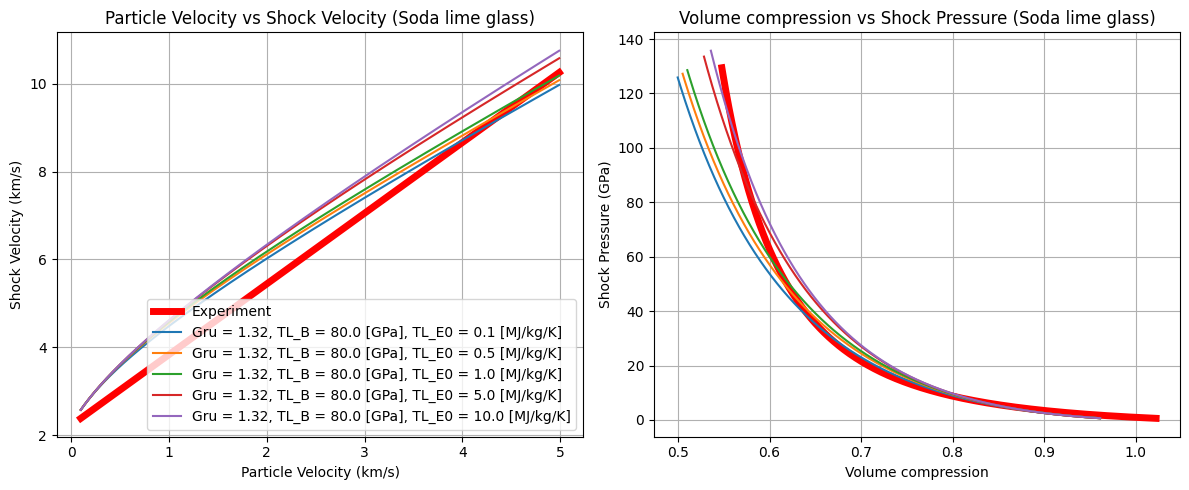

In [316]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
%matplotlib inline
from scipy.interpolate import interp1d

C0 = 2.22*1e3
s = 1.61
gruneisen_ratio = 1.32  # dimensionless

TL_RHO0 = 2.53E+03  # kg/m^3
TL_CHEAT = 7.53E+02  # J/kg/K
TL_BULKA = 4.54E+10  # Pa
print('Old Bulk A',TL_BULKA )
TL_BULKA = TL_RHO0* C0**2 # Pa
print('New Bulk A',TL_BULKA )
TL_THERMA = 5.00E-01  # dimensionless
TL_ALPHA = 5.00E+00  # dimensionless
TL_BETA = 5.00E+00  # dimensionless

E_int =  TL_CHEAT * 296# E = CvT = 1 [kJ/kg/K]* 300 [K] 
P_int = 1e5
##########################
##########################
TL_BULKBs = [64.1e9] 
TL_EZEROs = [50e3]
Grus = [0.9,1.32,2.0]
##########################
##########################
pre_tillos = []
shock_vel_tillos = []
particle_vel_tillos = []
labels = []

######
# 粒子速度の範囲を設定（m/s）
particle_vel = np.arange(0.1, 5.0, 0.01) * 1e3


Shock_vel_Hugo = C0+particle_vel*s
Shock_Pre_Hugo = TL_RHO0*particle_vel*Shock_vel_Hugo + P_int
Shock_Den_Hugo = TL_RHO0*Shock_vel_Hugo/(Shock_vel_Hugo-particle_vel)
Shock_Vol_Hugo = 1/Shock_Den_Hugo/vol_int

# プロット
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(particle_vel*1e-3, Shock_vel_Hugo*1e-3, label="Experiment", linewidth=5, c='red')
ax[1].plot(Shock_Vol_Hugo, Shock_Pre_Hugo * 1e-9, label="Experiment", linewidth=5, c='red')

# Tillotson EOS
def tillotson_eos(rho, E,TL_BULKB,TL_EZERO,b):
    mu = rho / TL_RHO0 - 1
    etha = mu + 1
    P = (
        (a + b / (E / (TL_EZERO * etha**2) + 1)) * rho * E
        + TL_BULKA * mu
        + TL_BULKB * mu**2
    )
    return P

# 連立方程式を定義
def equations(vars, v_p,TL_BULKB,TL_EZERO,TL_THERMB):
    rho, D, P = vars
    # 内部エネルギー E
    E = 0.5 * (P + P_int) * (1 / TL_RHO0 - 1 / rho)
    # Tillotson EOS
    eq1 = P - tillotson_eos(rho, E,TL_BULKB,TL_EZERO,TL_THERMB)
    # 運動量保存
    eq2 = (P - P_int) -  TL_RHO0*D*v_p
    # 質量保存
    eq3 = v_p*rho - (rho - TL_RHO0)*D
    return [eq1, eq2, eq3]



# 計算ループ
for i in np.arange(3,4,1):
    for j in np.arange(0,5,1):
        for k in np.arange(1,2,1):
            # 結果を保存するリスト
            shock_vel_valid = []
            pressure_valid = []
            volume_ratio_valid = []
            particle_vel_valid = []
            TL_BULKB = TL_BULKBs[i]
            TL_EZERO = TL_EZEROs[j]
            Gru = Grus[k]
            TL_THERMB = Gru-TL_THERMA 
            for v_p in particle_vel:
                # 初期値の設定 [rho, D, P]
                # vp=0 --> 1e5 pa
                # vp=1 --> 1e9 pa
                initial_guess = [TL_RHO0 * 1.1, 2.22*1e3+v_p * 1.61, 1e9+ v_p*20e6]
                sol = root(equations, initial_guess, args=(v_p,TL_BULKB,TL_EZERO,TL_THERMB), method="lm")
                if sol.success:
                    rho, D, P = sol.x
                    V_V0 = TL_RHO0 / rho  # 体積比 V/V0
                    particle_vel_valid.append(v_p)
                    shock_vel_valid.append(D)
                    pressure_valid.append(P)
                    volume_ratio_valid.append(V_V0)
                    # print(f"Success: v_p = {v_p / 1e3:.2f} km/s -> D = {D / 1e3:.2f} km/s, rho = {rho:.2f} kg/m^3, P = {P:.2e} Pa")
                else:
                    print(f"Failed to converge for v_p = {v_p / 1e3:.2f} km/s")
            
    
            # リストを numpy 配列に変換
            particle_vel_valid = np.array(particle_vel_valid)
            shock_vel_valid = np.array(shock_vel_valid)
            pressure_valid = np.array(pressure_valid)
            volume_ratio_valid = np.array(volume_ratio_valid)
            
            # 有効範囲内でのみ補間を行う
            interp_shock_vel = interp1d(particle_vel_valid, shock_vel_valid, kind="linear", bounds_error=False, fill_value=np.nan)
            interp_pressure = interp1d(particle_vel_valid, pressure_valid, kind="linear", bounds_error=False, fill_value=np.nan)
            interp_volume_ratio = interp1d(particle_vel_valid, volume_ratio_valid, kind="linear", bounds_error=False, fill_value=np.nan)
            
            # 有効範囲内の粒子速度を取得
            valid_range = (particle_vel >= particle_vel_valid.min()) & (particle_vel <= particle_vel_valid.max())
            particle_vel_interp = particle_vel[valid_range]
            
            # 補間後のデータを計算（有効範囲内）
            shock_vel_interp = interp_shock_vel(particle_vel_interp)
            pressure_interp = interp_pressure(particle_vel_interp)
            volume_ratio_interp = interp_volume_ratio(particle_vel_interp)
            
            # 異常値の除去（例：負の値や急激な変化）
            shock_vel_interp = np.where(shock_vel_interp < 0, np.nan, shock_vel_interp)
            pressure_interp = np.where(pressure_interp < 0, np.nan, pressure_interp)
            volume_ratio_interp = np.where(volume_ratio_interp < 0, np.nan, volume_ratio_interp)
            ax[0].plot(particle_vel_interp / 1e3, shock_vel_interp / 1e3, label="Gru = {}, TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(Gru,TL_BULKBs[i]*1e-9,round(TL_EZEROs[j]*1e-6,1)))
            ax[1].plot(volume_ratio_interp, pressure_interp * 1e-9, label="Gru = {}, TL_B = {} [GPa], TL_E0 = {} [MJ/kg/K]".format(Gru,TL_BULKBs[i]*1e-9,round(TL_EZEROs[j]*1e-6,1)))
       

# 粒子速度 vs 衝撃波速度
ax[0].set_xlabel("Particle Velocity (km/s)")
ax[0].set_ylabel("Shock Velocity (km/s)")
ax[0].set_title("Particle Velocity vs Shock Velocity (Soda lime glass)")
ax[0].grid(True)
# ax[0].legend()

# 圧縮 vs 衝撃圧力
ax[1].set_xlabel("Volume compression")
ax[1].set_ylabel("Shock Pressure (GPa)")
ax[1].set_title("Volume compression vs Shock Pressure (Soda lime glass)")
ax[1].grid(True)
# ax[1].legend()

plt.tight_layout()
# ax[0].plot(particle_vel / 1e3, shock_vel_valid / 1e3, label="Best Fit", linewidth=3, c="blue")
ax[0].legend()
plt.show()

Iteration 1: Params = [6.47000000e+10 5.00000000e+06 4.99996181e-01], Error = 63201.26153578716

Optimization Finished
Best Parameters: [6.47000000e+10 5.00000000e+06 4.99996181e-01]
Final Error: 63201.26153578716

Iteration Log:
Iteration 1: Params = [6.47000000e+10 5.00000000e+06 4.99996181e-01], Error = 63201.26153578716
Optimal TL_BULKB: 64700000000.0 Pa, TL_EZERO: 5000000.0 J/kg, a:0.4999961806850009


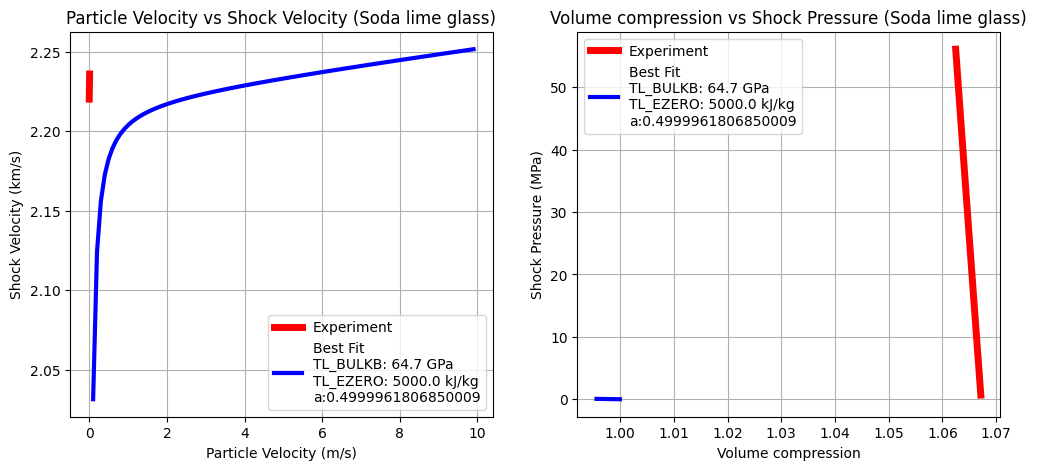

In [354]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution


TL_THERMB = 1.32-0.5
C0 = 2.22*1e3
s = 1.61
gruneisen_ratio = 1.32  
TL_RHO0 = 2.53E+03  # kg/m^3
TL_CHEAT = 7.53E+02  # J/kg/K
TL_BULKA = TL_RHO0* C0**2 # Pa
TL_THERMA = 5.00E-01  
TL_THERMB = 8.20E-01  
TL_ALPHA = 5.00E+00 
TL_BETA = 5.00E+00  
E_int =  TL_CHEAT * 296 
P_int = 1e5

melting_temperature = 1996  # K
vaporization_temperature = 3175  # K
mean_atomic_weight = 20.03  # g/mol
Eiv = 2.39E+06  # J/kg/K
Ecv = 1.43E+07  # J/kg/K

# 粒子速度の範囲を設定（m/s）
particle_vel = np.arange(0.0001, 0.01, 0.0001) * 1e3

Shock_vel_Hugo = C0+particle_vel*s
Shock_Pre_Hugo = TL_RHO0*particle_vel*Shock_vel_Hugo + P_int
Shock_Den_Hugo = TL_RHO0*Shock_vel_Hugo/(Shock_vel_Hugo-particle_vel)
Shock_Vol_Hugo = 1/Shock_Den_Hugo/vol_int


# 連立方程式を定義
def equations(vars, v_p,TL_BULKB,TL_EZERO,a):
    rho, D, P = vars
    # 内部エネルギー E
    E = 0.5 * (P + P_int) * (1 / TL_RHO0 - 1 / rho)
    # Tillotson EOS
    eq1 = P - tillotson_eos(rho, E,TL_BULKB,TL_EZERO,a)
    # 運動量保存
    eq2 = (P - P_int) -  TL_RHO0*D*v_p
    # 質量保存
    eq3 = v_p*rho - (rho - TL_RHO0)*D
    return [eq1, eq2, eq3]
    
# Tillotson EOS
def tillotson_eos(rho, E,TL_BULKB,TL_EZERO,a):
    mu = rho / TL_RHO0 - 1
    etha = mu + 1
    b= 1.32 - a
    P = ((a + b / (E / (TL_EZERO * etha**2) + 1)) * rho * E + TL_BULKA * mu + TL_BULKB * mu**2)
    return P


# 誤差関数
def fitting_error(params, particle_vel, Shock_vel_Hugo):
    TL_BULKB, TL_EZERO ,a= params
    shock_vel_valid = []
    for v_p in particle_vel:
        initial_guess = [TL_RHO0 * 1.1, 2.22*1e3+v_p * 1.61, 1e9+ v_p*20e6]
        sol = root(equations, initial_guess, args=(v_p, TL_BULKB, TL_EZERO,a), method="lm")
        if sol.success:
            rho, D, P = sol.x
            shock_vel_valid.append(D)
        else:
            shock_vel_valid.append(np.nan)
    shock_vel_valid = np.array(shock_vel_valid)
    # 実験値との差の二乗誤差を計算（無効値は除外）
    valid_mask = ~np.isnan(shock_vel_valid)
    error = np.sum((Shock_vel_Hugo[valid_mask] - shock_vel_valid[valid_mask])**2)
    return error

result = differential_evolution(fitting_error,bounds=bounds,
    args=(particle_vel, Shock_vel_Hugo),strategy='best1bin',
    maxiter=1000, tol=1e-9, disp=True)

iteration_log = []
def callback(params):
    # 現在のパラメータで誤差を計算
    error = fitting_error(params, particle_vel, Shock_vel_Hugo)
    iteration_log.append((params, error))
    print(f"Iteration {len(iteration_log)}: Params = {params}, Error = {error}")

# 初期値と境界条件
initial_guess = [6.47e10, 5e6, 5e-1]  # TL_BULKBとTL_EZEROの初期値
bounds = [(5e10, 8e10), (1e5, 1e7),(0,0.666666666)]    # 各パラメータの範囲


# 最適化の実行
result = minimize(
    fitting_error,
    initial_guess,
    args=(particle_vel, Shock_vel_Hugo),
    bounds=bounds,
    callback=callback,
    options={'disp': True}
)
# # 最適化の実行
# result = differential_evolution(
#     fitting_error,
#     bounds=bounds,
#     args=(particle_vel, Shock_vel_Hugo),
#     strategy='best1bin',
#     maxiter=1000,
#     tol=1e-9,
#     disp=True
# )

# 最適化結果の表示
print("\nOptimization Finished")
print(f"Best Parameters: {result.x}")
print(f"Final Error: {result.fun}")

# 全反復ログの出力
print("\nIteration Log:")
for i, (params, error) in enumerate(iteration_log):
    print(f"Iteration {i+1}: Params = {params}, Error = {error}")
    
# 最適なパラメータ
best_TL_BULKB, best_TL_EZERO , best_TL_a= result.x
print(f"Optimal TL_BULKB: {best_TL_BULKB} Pa, TL_EZERO: {best_TL_EZERO} J/kg, a:{best_TL_a}")

# 最適パラメータでプロット
shock_vel_valid = []
pre_valid = []
vol_valid = []
for v_p in particle_vel:
    # 初期値の設定 [rho, D, P]
    # vp=0 --> 1e5 pa
    # vp=1 --> 1e9 pa
    initial_guess = [TL_RHO0 * 1.1, 2.22*1e3+v_p * 1.61, 1e9+ v_p*20e6]
    sol = root(equations, initial_guess, args=(v_p, best_TL_BULKB, best_TL_EZERO,a), method="lm")
    if sol.success:
        rho, D, P = sol.x
        v= TL_RHO0/rho
        shock_vel_valid.append(D)
        pre_valid.append(P)
        vol_valid.append(v)
    else:
        shock_vel_valid.append(np.nan)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(particle_vel*1e-3, Shock_vel_Hugo*1e-3, label="Experiment", linewidth=5, c='red')
ax[1].plot(Shock_Vol_Hugo, Shock_Pre_Hugo * 1e-6, label="Experiment", linewidth=5, c='red')


# 粒子速度 vs 衝撃波速度
ax[0].set_xlabel("Particle Velocity (m/s)")
ax[0].set_ylabel("Shock Velocity (km/s)")
ax[0].set_title("Particle Velocity vs Shock Velocity (Soda lime glass)")
ax[0].grid(True)

# 圧縮 vs 衝撃圧力
ax[1].set_xlabel("Volume compression")
ax[1].set_ylabel("Shock Pressure (MPa)")
ax[1].set_title("Volume compression vs Shock Pressure (Soda lime glass)")
ax[1].grid(True)


shock_vel_valid = np.array(shock_vel_valid)
ax[0].plot(particle_vel, shock_vel_valid / 1e3, label=f"Best Fit\nTL_BULKB: {round(best_TL_BULKB*1e-9,1)} GPa\nTL_EZERO: {round(best_TL_EZERO*1e-3,2)} kJ/kg\na:{best_TL_a}", linewidth=3, c="blue")
ax[1].plot(vol_valid, np.array(pre_valid)*1e-9, label=f"Best Fit\nTL_BULKB: {round(best_TL_BULKB*1e-9,1)} GPa\nTL_EZERO: {round(best_TL_EZERO*1e-3,2)} kJ/kg\na:{best_TL_a}", linewidth=3, c="blue")
ax[0].legend()
ax[1].legend()
plt.show()
